# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████████████████████████████████████████████| 60.0K/60.0K [02:54<00:00, 345File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

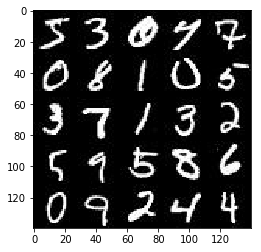

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

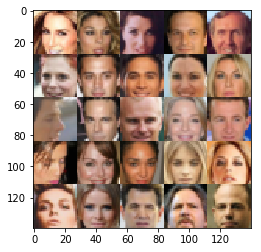

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [62]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    rl_inpt_img = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="input_real")
    z_data = tf.placeholder(tf.float32,(None,z_dim),name="input_z")
    lr = tf.placeholder(tf.float32,(None))
    return rl_inpt_img,z_data,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Program Files\\Anaconda3\\lib\\runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Program Files\\Anaconda3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Program Files\\Anaconda3\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "C:\\Program Files\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Program Files\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Program Files\\Anaconda3\\lib\\site-packages\\zmq\\eventloop\\io

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [77]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    initializer=tf.contrib.layers.xavier_initializer
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images,64,4,strides=2,padding="same",kernel_regularizer=initializer) 
        x1 = tf.layers.batch_normalization(x1,training=True)
        x1 = tf.layers.dropout(x1,rate=0.1)
        relu1 = tf.maximum(alpha*x1,x1)
        
        
        x2 = tf.layers.conv2d(relu1,128,4,strides=2,padding="same")
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.layers.dropout(x2,rate=0.1)
        relu2 = tf.maximum(alpha*x2,x2)
        
        
        x3  = tf.layers.conv2d(relu2,256,4,strides=2,padding="same")
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.layers.dropout(x3,rate=0.1)
        relu3 = tf.maximum(alpha*x3,x3)
        
        
        flat = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    

    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [97]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #print(out_channel_dim)
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.2
    initializer=tf.contrib.layers.xavier_initializer
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z,4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        #print(x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid',kernel_regularizer=initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        #x2 = tf.layers.dropout(x2,rate=0.1,training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        #print(x2.shape)
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.layers.dropout(x3,rate=0.1,training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        #print(x3.shape)
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        #logits = tf.layers.dropout(logits,rate=0.1,training=is_train)
        # 32x32x3 now
        #print(logits.shape)
        out = tf.tanh(logits)
        #print(out.shape)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [98]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1-smooth)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [99]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [100]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [101]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step = step+1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print('batch_z shape=',batch_z.shape)
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate})
                
                if step % 100 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, step),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    

                if step % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 100... Discriminator Loss: 1.4141... Generator Loss: 0.7748
Epoch 1/2 Step 200... Discriminator Loss: 1.3734... Generator Loss: 1.4059


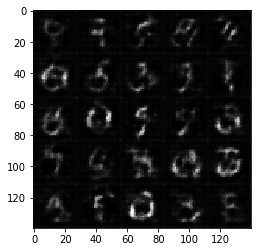

Epoch 1/2 Step 300... Discriminator Loss: 1.3789... Generator Loss: 0.6159
Epoch 1/2 Step 400... Discriminator Loss: 1.6342... Generator Loss: 0.4497


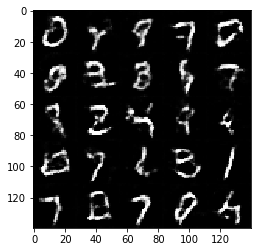

Epoch 1/2 Step 500... Discriminator Loss: 1.2721... Generator Loss: 0.6214
Epoch 1/2 Step 600... Discriminator Loss: 1.2565... Generator Loss: 0.6563


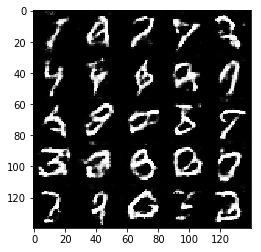

Epoch 1/2 Step 700... Discriminator Loss: 1.0241... Generator Loss: 1.0473
Epoch 1/2 Step 800... Discriminator Loss: 1.1120... Generator Loss: 1.0267


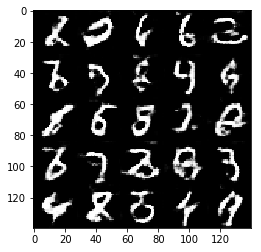

Epoch 1/2 Step 900... Discriminator Loss: 1.0392... Generator Loss: 1.4226
Epoch 2/2 Step 1000... Discriminator Loss: 0.9773... Generator Loss: 0.9500


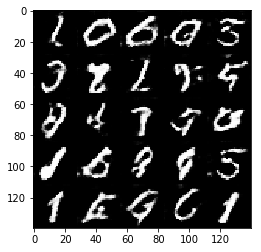

Epoch 2/2 Step 1100... Discriminator Loss: 1.1913... Generator Loss: 2.0128
Epoch 2/2 Step 1200... Discriminator Loss: 0.8805... Generator Loss: 1.0483


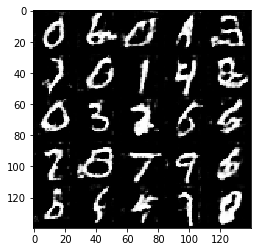

Epoch 2/2 Step 1300... Discriminator Loss: 1.0234... Generator Loss: 1.2800
Epoch 2/2 Step 1400... Discriminator Loss: 0.7828... Generator Loss: 1.5244


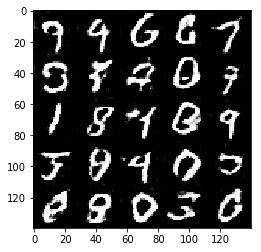

Epoch 2/2 Step 1500... Discriminator Loss: 1.0053... Generator Loss: 0.8587
Epoch 2/2 Step 1600... Discriminator Loss: 0.4814... Generator Loss: 2.1255


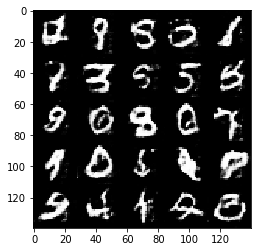

Epoch 2/2 Step 1700... Discriminator Loss: 0.6259... Generator Loss: 1.5262
Epoch 2/2 Step 1800... Discriminator Loss: 1.2225... Generator Loss: 1.2013


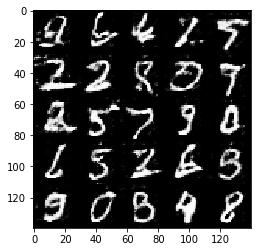

In [102]:
batch_size = 64
z_dim = 100
learning_rate = 1e-03
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10 Step 100... Discriminator Loss: 1.4169... Generator Loss: 0.6045
Epoch 1/10 Step 200... Discriminator Loss: 1.1118... Generator Loss: 0.7444


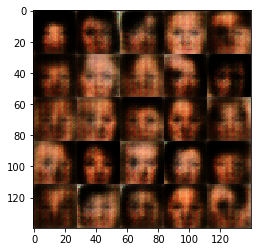

Epoch 1/10 Step 300... Discriminator Loss: 1.8943... Generator Loss: 1.9253
Epoch 1/10 Step 400... Discriminator Loss: 1.0762... Generator Loss: 2.4522


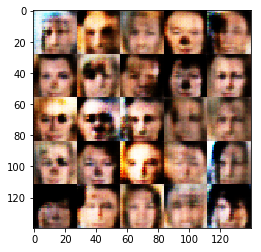

Epoch 1/10 Step 500... Discriminator Loss: 1.2738... Generator Loss: 1.2518
Epoch 1/10 Step 600... Discriminator Loss: 1.0530... Generator Loss: 1.2708


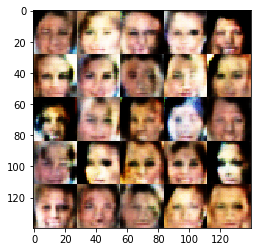

Epoch 1/10 Step 700... Discriminator Loss: 0.5866... Generator Loss: 2.3735
Epoch 1/10 Step 800... Discriminator Loss: 1.1954... Generator Loss: 0.6944


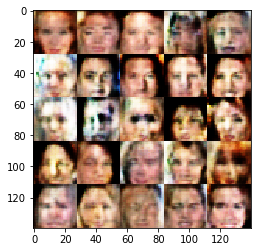

Epoch 1/10 Step 900... Discriminator Loss: 0.7071... Generator Loss: 1.3314
Epoch 1/10 Step 1000... Discriminator Loss: 0.9852... Generator Loss: 0.8879


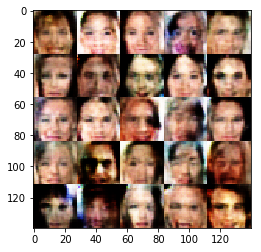

Epoch 1/10 Step 1100... Discriminator Loss: 0.8511... Generator Loss: 0.9607
Epoch 1/10 Step 1200... Discriminator Loss: 1.1047... Generator Loss: 1.9898


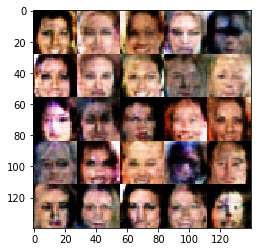

Epoch 1/10 Step 1300... Discriminator Loss: 0.9323... Generator Loss: 4.9826
Epoch 1/10 Step 1400... Discriminator Loss: 0.6183... Generator Loss: 3.3594


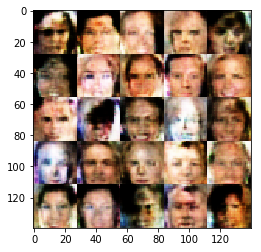

Epoch 1/10 Step 1500... Discriminator Loss: 0.6306... Generator Loss: 2.3678
Epoch 1/10 Step 1600... Discriminator Loss: 1.0696... Generator Loss: 1.4827


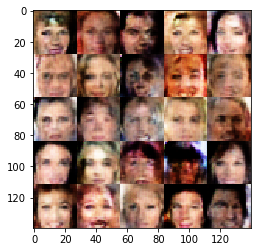

Epoch 1/10 Step 1700... Discriminator Loss: 0.4677... Generator Loss: 2.5988
Epoch 1/10 Step 1800... Discriminator Loss: 1.3978... Generator Loss: 3.2630


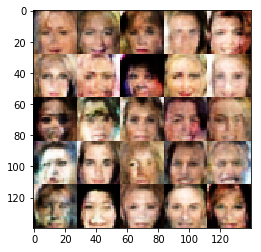

Epoch 1/10 Step 1900... Discriminator Loss: 0.8791... Generator Loss: 1.5183
Epoch 1/10 Step 2000... Discriminator Loss: 1.2577... Generator Loss: 0.6283


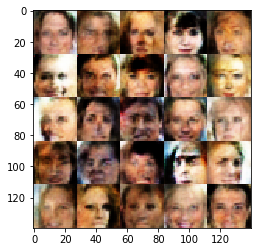

Epoch 2/10 Step 2100... Discriminator Loss: 1.0164... Generator Loss: 0.8146
Epoch 2/10 Step 2200... Discriminator Loss: 0.5542... Generator Loss: 4.4390


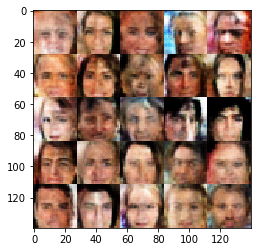

Epoch 2/10 Step 2300... Discriminator Loss: 0.4061... Generator Loss: 2.6938
Epoch 2/10 Step 2400... Discriminator Loss: 1.0703... Generator Loss: 2.2297


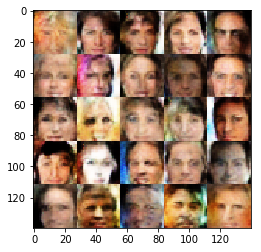

Epoch 2/10 Step 2500... Discriminator Loss: 0.9829... Generator Loss: 0.8511
Epoch 2/10 Step 2600... Discriminator Loss: 1.2852... Generator Loss: 2.6228


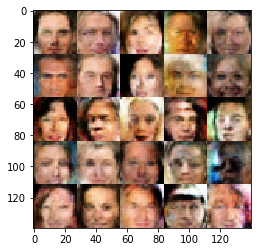

Epoch 2/10 Step 2700... Discriminator Loss: 1.6192... Generator Loss: 0.4873
Epoch 2/10 Step 2800... Discriminator Loss: 0.4060... Generator Loss: 2.8500


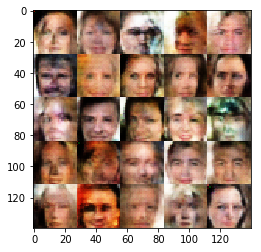

Epoch 2/10 Step 2900... Discriminator Loss: 0.7160... Generator Loss: 2.5988
Epoch 2/10 Step 3000... Discriminator Loss: 0.6559... Generator Loss: 1.6778


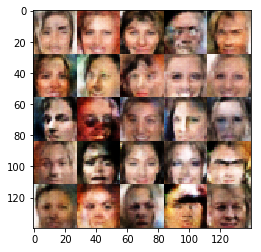

Epoch 2/10 Step 3100... Discriminator Loss: 0.4360... Generator Loss: 2.4493
Epoch 2/10 Step 3200... Discriminator Loss: 0.3767... Generator Loss: 3.2555


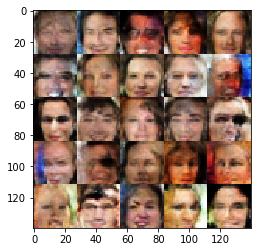

Epoch 2/10 Step 3300... Discriminator Loss: 0.4613... Generator Loss: 2.6862
Epoch 2/10 Step 3400... Discriminator Loss: 1.6873... Generator Loss: 3.8757


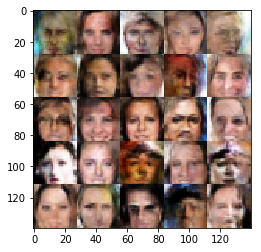

Epoch 2/10 Step 3500... Discriminator Loss: 0.8201... Generator Loss: 1.1024
Epoch 2/10 Step 3600... Discriminator Loss: 0.6106... Generator Loss: 3.1410


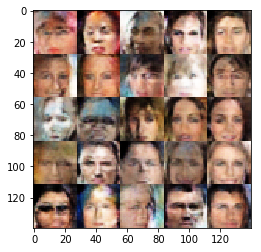

Epoch 2/10 Step 3700... Discriminator Loss: 0.7192... Generator Loss: 1.7734
Epoch 2/10 Step 3800... Discriminator Loss: 0.5594... Generator Loss: 1.6509


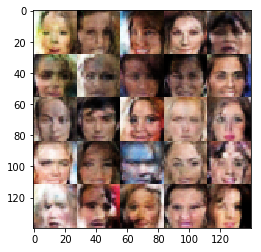

Epoch 2/10 Step 3900... Discriminator Loss: 1.2024... Generator Loss: 3.2178
Epoch 2/10 Step 4000... Discriminator Loss: 0.7488... Generator Loss: 2.0559


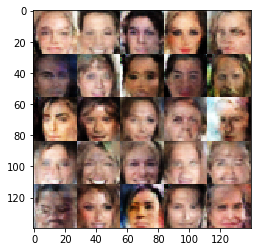

Epoch 3/10 Step 4100... Discriminator Loss: 0.5638... Generator Loss: 1.7185
Epoch 3/10 Step 4200... Discriminator Loss: 1.1444... Generator Loss: 0.8384


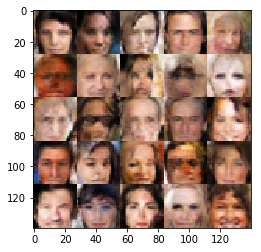

Epoch 3/10 Step 4300... Discriminator Loss: 0.9337... Generator Loss: 1.9052
Epoch 3/10 Step 4400... Discriminator Loss: 0.7403... Generator Loss: 4.4687


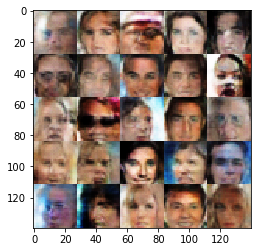

Epoch 3/10 Step 4500... Discriminator Loss: 0.8127... Generator Loss: 1.9005
Epoch 3/10 Step 4600... Discriminator Loss: 0.8009... Generator Loss: 1.4778


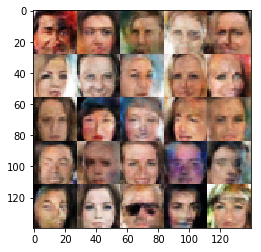

Epoch 3/10 Step 4700... Discriminator Loss: 0.6875... Generator Loss: 1.3231
Epoch 3/10 Step 4800... Discriminator Loss: 0.4828... Generator Loss: 3.6461


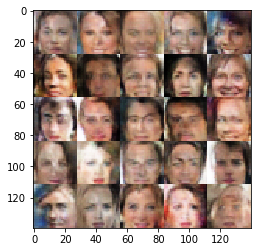

Epoch 3/10 Step 4900... Discriminator Loss: 0.4055... Generator Loss: 2.8844
Epoch 3/10 Step 5000... Discriminator Loss: 0.6515... Generator Loss: 2.1121


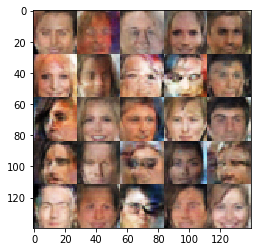

Epoch 3/10 Step 5100... Discriminator Loss: 1.1140... Generator Loss: 0.7551
Epoch 3/10 Step 5200... Discriminator Loss: 0.8989... Generator Loss: 2.0440


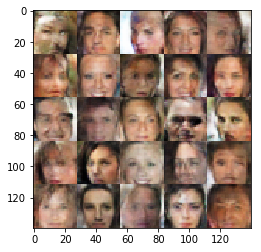

Epoch 3/10 Step 5300... Discriminator Loss: 0.7629... Generator Loss: 1.1204
Epoch 3/10 Step 5400... Discriminator Loss: 0.5340... Generator Loss: 1.8737


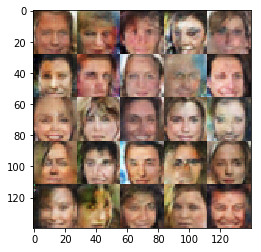

Epoch 3/10 Step 5500... Discriminator Loss: 0.5416... Generator Loss: 2.1373
Epoch 3/10 Step 5600... Discriminator Loss: 0.4971... Generator Loss: 2.0263


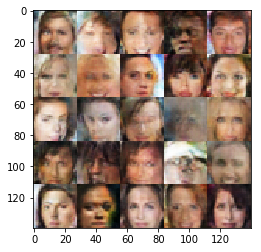

Epoch 3/10 Step 5700... Discriminator Loss: 0.5279... Generator Loss: 1.8446
Epoch 3/10 Step 5800... Discriminator Loss: 0.5553... Generator Loss: 2.2693


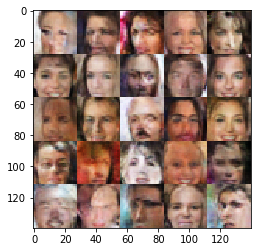

Epoch 3/10 Step 5900... Discriminator Loss: 0.7063... Generator Loss: 1.2435
Epoch 3/10 Step 6000... Discriminator Loss: 1.4615... Generator Loss: 0.5540


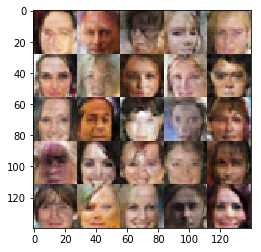

Epoch 4/10 Step 6100... Discriminator Loss: 0.9892... Generator Loss: 2.2574
Epoch 4/10 Step 6200... Discriminator Loss: 2.6379... Generator Loss: 4.0136


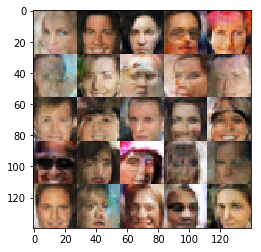

Epoch 4/10 Step 6300... Discriminator Loss: 1.6392... Generator Loss: 0.4842
Epoch 4/10 Step 6400... Discriminator Loss: 0.5151... Generator Loss: 1.8687


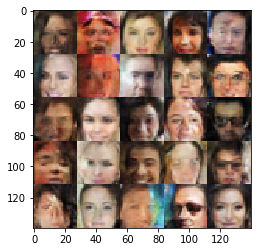

Epoch 4/10 Step 6500... Discriminator Loss: 1.2022... Generator Loss: 0.7032
Epoch 4/10 Step 6600... Discriminator Loss: 0.4688... Generator Loss: 2.1649


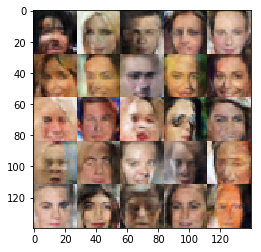

Epoch 4/10 Step 6700... Discriminator Loss: 0.5798... Generator Loss: 3.2145
Epoch 4/10 Step 6800... Discriminator Loss: 0.9641... Generator Loss: 1.9375


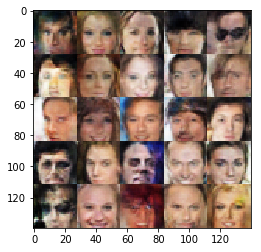

Epoch 4/10 Step 6900... Discriminator Loss: 0.9859... Generator Loss: 0.9049
Epoch 4/10 Step 7000... Discriminator Loss: 0.4573... Generator Loss: 2.2269


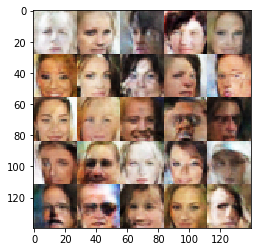

Epoch 4/10 Step 7100... Discriminator Loss: 0.3803... Generator Loss: 3.5768
Epoch 4/10 Step 7200... Discriminator Loss: 0.5815... Generator Loss: 2.7588


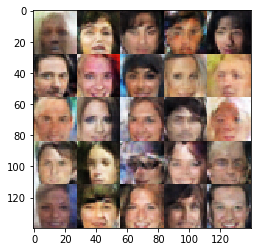

Epoch 4/10 Step 7300... Discriminator Loss: 0.4842... Generator Loss: 2.5174
Epoch 4/10 Step 7400... Discriminator Loss: 0.5288... Generator Loss: 1.8437


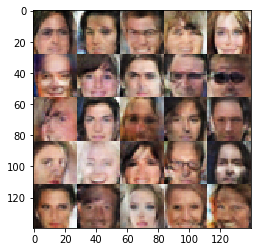

Epoch 4/10 Step 7500... Discriminator Loss: 0.4115... Generator Loss: 2.9020
Epoch 4/10 Step 7600... Discriminator Loss: 0.4504... Generator Loss: 2.3754


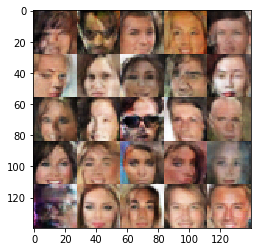

Epoch 4/10 Step 7700... Discriminator Loss: 1.2008... Generator Loss: 0.7150
Epoch 4/10 Step 7800... Discriminator Loss: 0.6136... Generator Loss: 3.1209


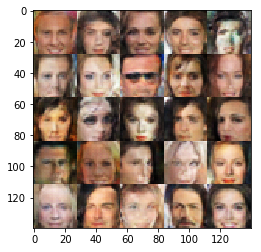

Epoch 4/10 Step 7900... Discriminator Loss: 1.2341... Generator Loss: 0.6501
Epoch 4/10 Step 8000... Discriminator Loss: 0.8839... Generator Loss: 1.0267


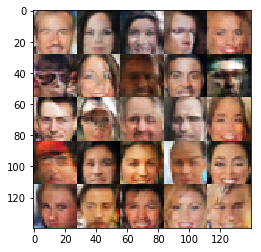

Epoch 4/10 Step 8100... Discriminator Loss: 1.3975... Generator Loss: 0.6020
Epoch 5/10 Step 8200... Discriminator Loss: 0.4081... Generator Loss: 3.6182


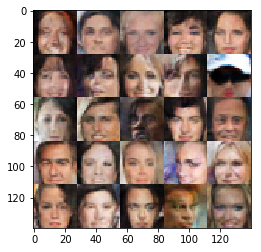

Epoch 5/10 Step 8300... Discriminator Loss: 0.6411... Generator Loss: 1.6949
Epoch 5/10 Step 8400... Discriminator Loss: 0.7821... Generator Loss: 1.1640


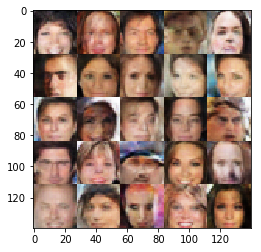

Epoch 5/10 Step 8500... Discriminator Loss: 0.4188... Generator Loss: 3.0495
Epoch 5/10 Step 8600... Discriminator Loss: 0.8859... Generator Loss: 4.6354


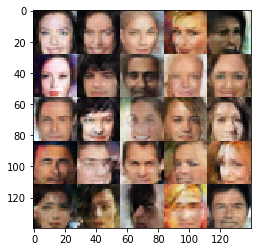

Epoch 5/10 Step 8700... Discriminator Loss: 0.8013... Generator Loss: 3.7417
Epoch 5/10 Step 8800... Discriminator Loss: 1.7585... Generator Loss: 0.4673


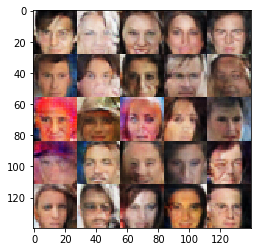

Epoch 5/10 Step 8900... Discriminator Loss: 0.4291... Generator Loss: 2.6751
Epoch 5/10 Step 9000... Discriminator Loss: 0.3997... Generator Loss: 2.9552


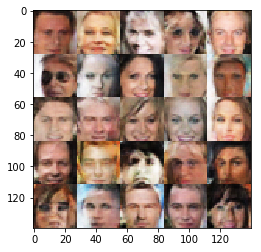

Epoch 5/10 Step 9100... Discriminator Loss: 1.0691... Generator Loss: 0.7876
Epoch 5/10 Step 9200... Discriminator Loss: 1.4908... Generator Loss: 0.5926


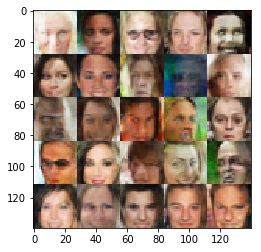

Epoch 5/10 Step 9300... Discriminator Loss: 0.4052... Generator Loss: 2.7550
Epoch 5/10 Step 9400... Discriminator Loss: 2.4950... Generator Loss: 3.4486


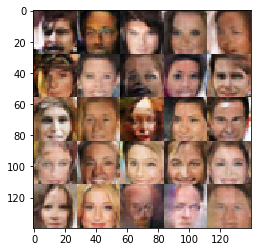

Epoch 5/10 Step 9500... Discriminator Loss: 0.6645... Generator Loss: 1.3454
Epoch 5/10 Step 9600... Discriminator Loss: 0.7371... Generator Loss: 1.3170


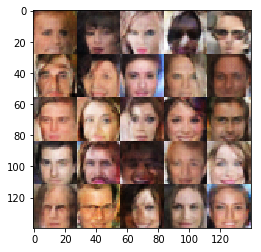

Epoch 5/10 Step 9700... Discriminator Loss: 0.3619... Generator Loss: 3.9931
Epoch 5/10 Step 9800... Discriminator Loss: 0.5467... Generator Loss: 2.0535


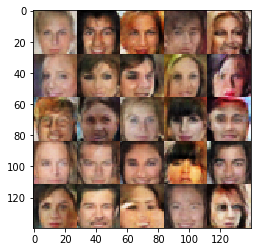

Epoch 5/10 Step 9900... Discriminator Loss: 1.3065... Generator Loss: 0.6931
Epoch 5/10 Step 10000... Discriminator Loss: 1.2818... Generator Loss: 0.6501


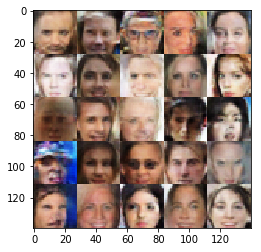

Epoch 5/10 Step 10100... Discriminator Loss: 0.8471... Generator Loss: 2.3467
Epoch 6/10 Step 10200... Discriminator Loss: 0.4724... Generator Loss: 2.2768


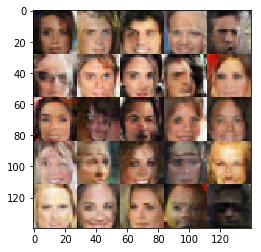

Epoch 6/10 Step 10300... Discriminator Loss: 0.4752... Generator Loss: 2.3528
Epoch 6/10 Step 10400... Discriminator Loss: 0.4034... Generator Loss: 3.2969


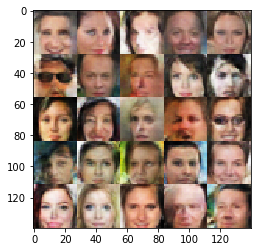

Epoch 6/10 Step 10500... Discriminator Loss: 1.5253... Generator Loss: 0.9154
Epoch 6/10 Step 10600... Discriminator Loss: 0.7479... Generator Loss: 1.2703


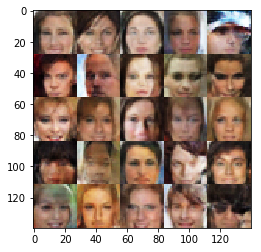

Epoch 6/10 Step 10700... Discriminator Loss: 0.7775... Generator Loss: 1.5685
Epoch 6/10 Step 10800... Discriminator Loss: 0.4891... Generator Loss: 3.2076


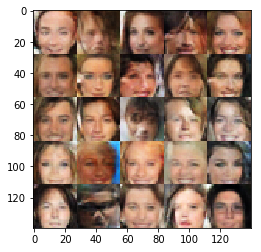

Epoch 6/10 Step 10900... Discriminator Loss: 0.4788... Generator Loss: 2.1580
Epoch 6/10 Step 11000... Discriminator Loss: 1.6950... Generator Loss: 1.7452


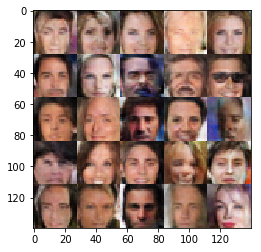

Epoch 6/10 Step 11100... Discriminator Loss: 0.5008... Generator Loss: 2.0460
Epoch 6/10 Step 11200... Discriminator Loss: 0.6457... Generator Loss: 2.1497


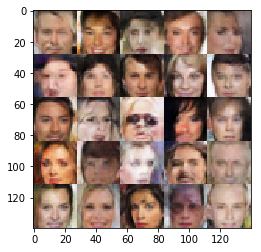

Epoch 6/10 Step 11300... Discriminator Loss: 0.8303... Generator Loss: 2.7936
Epoch 6/10 Step 11400... Discriminator Loss: 0.8242... Generator Loss: 1.1344


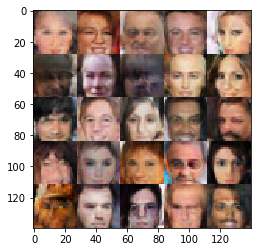

Epoch 6/10 Step 11500... Discriminator Loss: 0.4666... Generator Loss: 3.9802
Epoch 6/10 Step 11600... Discriminator Loss: 1.5879... Generator Loss: 0.5327


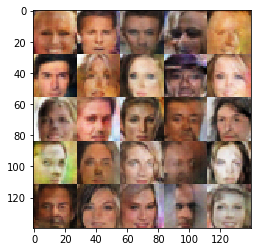

Epoch 6/10 Step 11700... Discriminator Loss: 0.9017... Generator Loss: 1.7378
Epoch 6/10 Step 11800... Discriminator Loss: 0.5210... Generator Loss: 1.9023


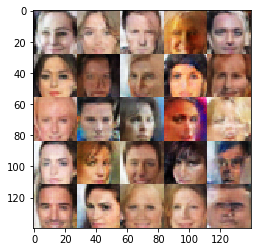

Epoch 6/10 Step 11900... Discriminator Loss: 0.5878... Generator Loss: 2.0052
Epoch 6/10 Step 12000... Discriminator Loss: 0.7186... Generator Loss: 1.4287


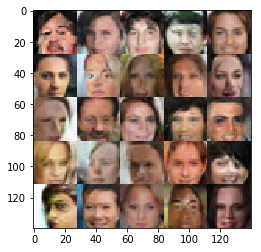

Epoch 6/10 Step 12100... Discriminator Loss: 0.7371... Generator Loss: 2.0942
Epoch 7/10 Step 12200... Discriminator Loss: 0.3740... Generator Loss: 3.5895


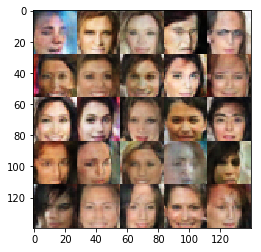

Epoch 7/10 Step 12300... Discriminator Loss: 0.3886... Generator Loss: 3.2733
Epoch 7/10 Step 12400... Discriminator Loss: 1.1394... Generator Loss: 3.1538


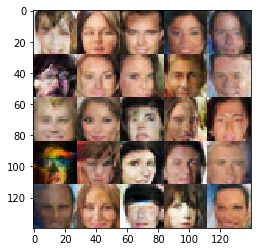

Epoch 7/10 Step 12500... Discriminator Loss: 0.6650... Generator Loss: 2.6737
Epoch 7/10 Step 12600... Discriminator Loss: 0.4409... Generator Loss: 2.5742


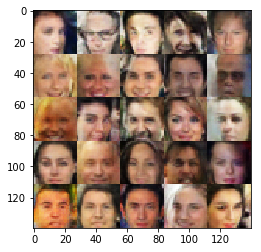

Epoch 7/10 Step 12700... Discriminator Loss: 0.5768... Generator Loss: 2.0253
Epoch 7/10 Step 12800... Discriminator Loss: 1.1622... Generator Loss: 2.5640


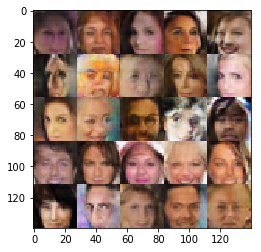

Epoch 7/10 Step 12900... Discriminator Loss: 0.8192... Generator Loss: 2.3787
Epoch 7/10 Step 13000... Discriminator Loss: 0.6211... Generator Loss: 2.4602


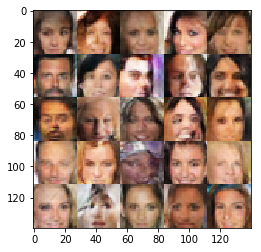

Epoch 7/10 Step 13100... Discriminator Loss: 0.8693... Generator Loss: 4.2705
Epoch 7/10 Step 13200... Discriminator Loss: 0.6846... Generator Loss: 1.3962


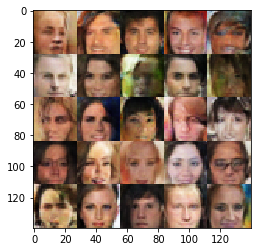

Epoch 7/10 Step 13300... Discriminator Loss: 0.4299... Generator Loss: 3.2797
Epoch 7/10 Step 13400... Discriminator Loss: 1.3730... Generator Loss: 0.7484


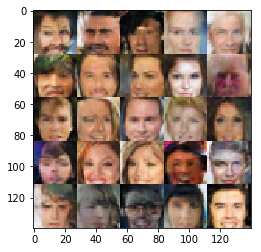

Epoch 7/10 Step 13500... Discriminator Loss: 1.9288... Generator Loss: 0.4570
Epoch 7/10 Step 13600... Discriminator Loss: 0.4516... Generator Loss: 2.4687


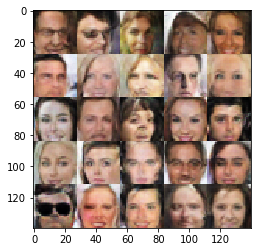

Epoch 7/10 Step 13700... Discriminator Loss: 0.5012... Generator Loss: 2.0602
Epoch 7/10 Step 13800... Discriminator Loss: 1.0699... Generator Loss: 2.8745


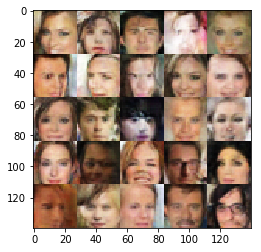

Epoch 7/10 Step 13900... Discriminator Loss: 1.0759... Generator Loss: 0.8075
Epoch 7/10 Step 14000... Discriminator Loss: 1.0687... Generator Loss: 2.9371


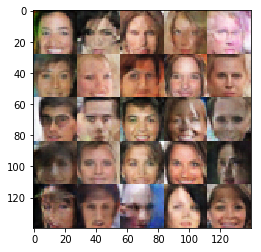

Epoch 7/10 Step 14100... Discriminator Loss: 0.6904... Generator Loss: 1.3874
Epoch 8/10 Step 14200... Discriminator Loss: 0.5258... Generator Loss: 1.8479


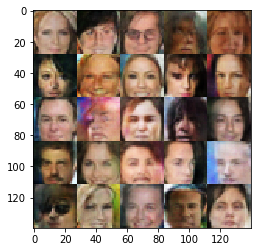

Epoch 8/10 Step 14300... Discriminator Loss: 0.6520... Generator Loss: 1.5200
Epoch 8/10 Step 14400... Discriminator Loss: 0.4742... Generator Loss: 3.4051


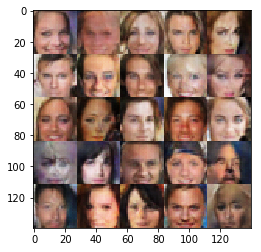

Epoch 8/10 Step 14500... Discriminator Loss: 0.4315... Generator Loss: 2.8502
Epoch 8/10 Step 14600... Discriminator Loss: 0.4266... Generator Loss: 2.7339


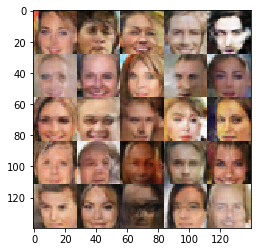

Epoch 8/10 Step 14700... Discriminator Loss: 0.6874... Generator Loss: 1.5912
Epoch 8/10 Step 14800... Discriminator Loss: 0.4655... Generator Loss: 2.5150


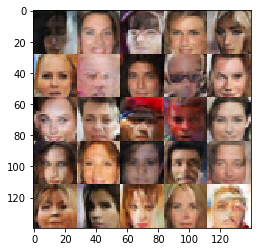

Epoch 8/10 Step 14900... Discriminator Loss: 1.1126... Generator Loss: 0.8489
Epoch 8/10 Step 15000... Discriminator Loss: 2.0260... Generator Loss: 0.4440


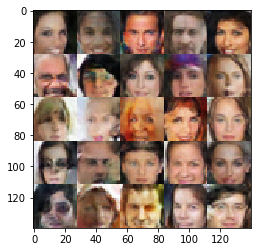

Epoch 8/10 Step 15100... Discriminator Loss: 0.4437... Generator Loss: 2.6864
Epoch 8/10 Step 15200... Discriminator Loss: 0.5023... Generator Loss: 2.3112


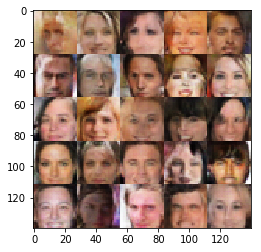

Epoch 8/10 Step 15300... Discriminator Loss: 1.0772... Generator Loss: 0.9107
Epoch 8/10 Step 15400... Discriminator Loss: 0.3781... Generator Loss: 3.5684


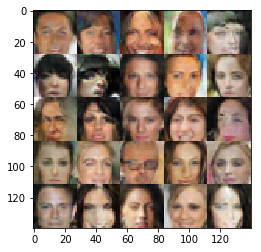

Epoch 8/10 Step 15500... Discriminator Loss: 1.5600... Generator Loss: 0.5542
Epoch 8/10 Step 15600... Discriminator Loss: 1.2609... Generator Loss: 0.7292


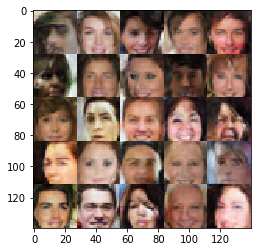

Epoch 8/10 Step 15700... Discriminator Loss: 1.7216... Generator Loss: 3.6657
Epoch 8/10 Step 15800... Discriminator Loss: 0.6417... Generator Loss: 1.8250


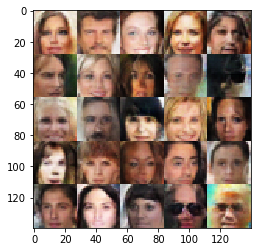

Epoch 8/10 Step 15900... Discriminator Loss: 0.6740... Generator Loss: 3.7710
Epoch 8/10 Step 16000... Discriminator Loss: 1.6343... Generator Loss: 0.5553


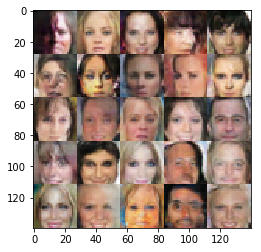

Epoch 8/10 Step 16100... Discriminator Loss: 0.4334... Generator Loss: 3.0306
Epoch 8/10 Step 16200... Discriminator Loss: 1.0162... Generator Loss: 0.8726


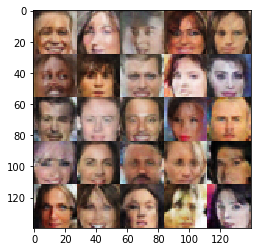

Epoch 9/10 Step 16300... Discriminator Loss: 1.1585... Generator Loss: 0.7120
Epoch 9/10 Step 16400... Discriminator Loss: 0.5427... Generator Loss: 1.8871


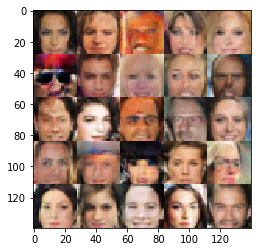

Epoch 9/10 Step 16500... Discriminator Loss: 0.6882... Generator Loss: 1.3823
Epoch 9/10 Step 16600... Discriminator Loss: 0.9829... Generator Loss: 0.8668


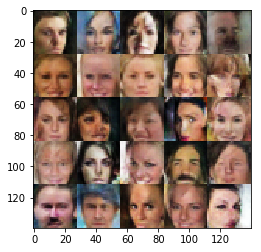

Epoch 9/10 Step 16700... Discriminator Loss: 0.4053... Generator Loss: 3.1811
Epoch 9/10 Step 16800... Discriminator Loss: 0.5620... Generator Loss: 1.9264


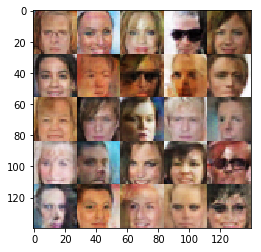

Epoch 9/10 Step 16900... Discriminator Loss: 1.5132... Generator Loss: 0.5634
Epoch 9/10 Step 17000... Discriminator Loss: 1.4641... Generator Loss: 0.6578


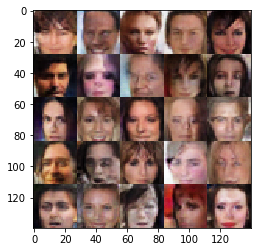

Epoch 9/10 Step 17100... Discriminator Loss: 0.4704... Generator Loss: 2.4450
Epoch 9/10 Step 17200... Discriminator Loss: 0.4488... Generator Loss: 3.0763


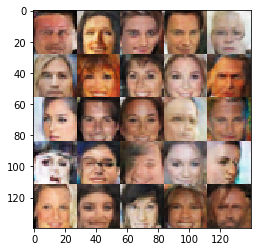

Epoch 9/10 Step 17300... Discriminator Loss: 2.2472... Generator Loss: 3.5598
Epoch 9/10 Step 17400... Discriminator Loss: 0.3792... Generator Loss: 3.6416


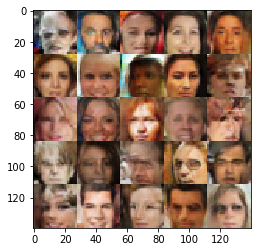

Epoch 9/10 Step 17500... Discriminator Loss: 1.0042... Generator Loss: 3.0575
Epoch 9/10 Step 17600... Discriminator Loss: 1.5488... Generator Loss: 0.6499


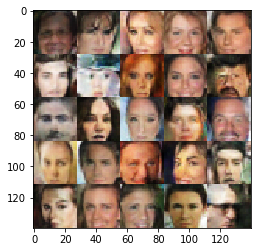

Epoch 9/10 Step 17700... Discriminator Loss: 1.0043... Generator Loss: 0.9208
Epoch 9/10 Step 17800... Discriminator Loss: 0.6590... Generator Loss: 2.1058


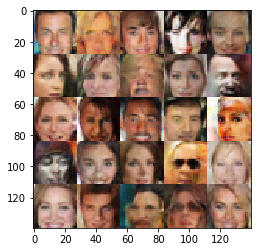

Epoch 9/10 Step 17900... Discriminator Loss: 0.5208... Generator Loss: 3.8868
Epoch 9/10 Step 18000... Discriminator Loss: 0.6476... Generator Loss: 1.4943


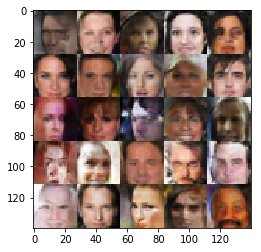

Epoch 9/10 Step 18100... Discriminator Loss: 1.2462... Generator Loss: 0.7007
Epoch 9/10 Step 18200... Discriminator Loss: 0.4616... Generator Loss: 3.2736


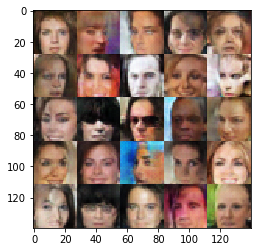

Epoch 10/10 Step 18300... Discriminator Loss: 0.6304... Generator Loss: 2.1199
Epoch 10/10 Step 18400... Discriminator Loss: 0.4802... Generator Loss: 2.1906


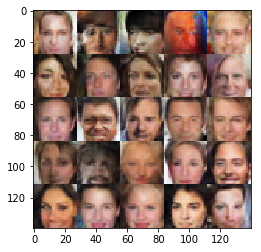

Epoch 10/10 Step 18500... Discriminator Loss: 0.4610... Generator Loss: 3.7599
Epoch 10/10 Step 18600... Discriminator Loss: 1.6805... Generator Loss: 0.5621


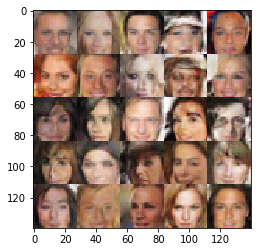

Epoch 10/10 Step 18700... Discriminator Loss: 0.7413... Generator Loss: 1.3595
Epoch 10/10 Step 18800... Discriminator Loss: 0.8940... Generator Loss: 1.2423


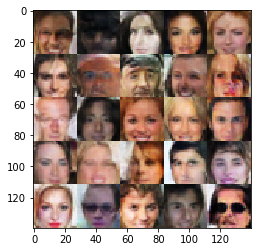

Epoch 10/10 Step 18900... Discriminator Loss: 0.4393... Generator Loss: 2.5437
Epoch 10/10 Step 19000... Discriminator Loss: 0.4658... Generator Loss: 3.3888


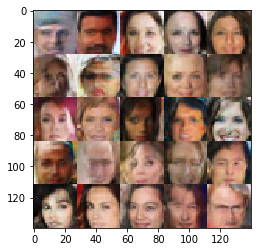

Epoch 10/10 Step 19100... Discriminator Loss: 0.6636... Generator Loss: 1.7809
Epoch 10/10 Step 19200... Discriminator Loss: 0.6124... Generator Loss: 1.5523


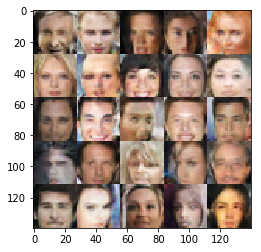

Epoch 10/10 Step 19300... Discriminator Loss: 0.7812... Generator Loss: 2.5780
Epoch 10/10 Step 19400... Discriminator Loss: 0.5205... Generator Loss: 1.9878


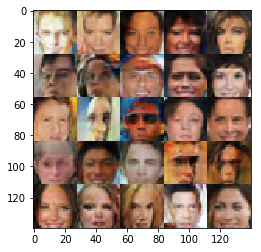

Epoch 10/10 Step 19500... Discriminator Loss: 1.5751... Generator Loss: 0.5689
Epoch 10/10 Step 19600... Discriminator Loss: 0.5818... Generator Loss: 1.7403


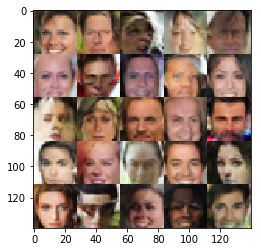

Epoch 10/10 Step 19700... Discriminator Loss: 1.2517... Generator Loss: 0.7077
Epoch 10/10 Step 19800... Discriminator Loss: 0.5152... Generator Loss: 2.0250


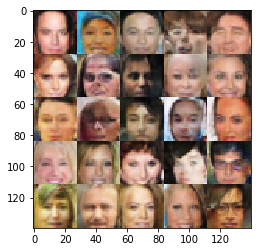

Epoch 10/10 Step 19900... Discriminator Loss: 0.3905... Generator Loss: 3.4577
Epoch 10/10 Step 20000... Discriminator Loss: 1.4780... Generator Loss: 2.6468


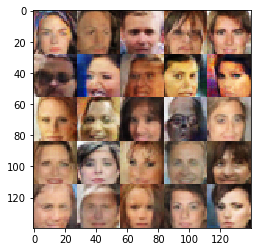

Epoch 10/10 Step 20100... Discriminator Loss: 0.4842... Generator Loss: 2.2532
Epoch 10/10 Step 20200... Discriminator Loss: 0.5272... Generator Loss: 2.1506


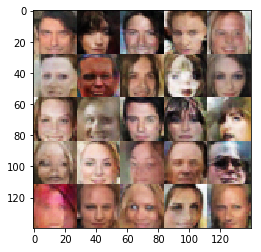

In [107]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.